In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import linalg as LA
from sklearn import tree
from sklearn.metrics import accuracy_score,classification_report,cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve,GridSearchCV, ParameterGrid, cross_validate, StratifiedKFold,RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss,CondensedNearestNeighbour
from collections import Counter
from kmodes.kmodes import KModes
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2
#conda install imbalanced-learn
# pip install kmodes

In [2]:
##### BUSINESS PROBLEM DESCRIPTION
## Ha senso investire soldi per fare advertising per ristorazione con i coupon attraverso le metriche
## raccolte dai dispositivi di geolocalizzazione? Sarebbe un business model monetizzabile? 
## Quale segmento di clientela potrebbe essere più responsive alla call to action? 
## Che abitudini ha la clientela che sarebbe responsive? 
## Che caratteristiche deve avere il coupon per essere interessante? (Distanza, Expiration date, 
# Tipologia di ristorante, Comodità per l'utente in viaggio [direzione], 
# Dove sta andando l'utente [destinazione], con chi è [passenger (magari giovani con amici che stanno uscendo a divertirsi????)])
######## Lavoratori che vanno a lavoro? 
## Ci sarebbe un periodo 


##### GENERAL STUFF 
## A noi interessa essere più accurati sullo scoprire quelli che useranno il coupon o quello che non lo useranno?
## ne dipende la metrica del modello, e le implicazioni di business sul come agire (nel caso si usino risorse per 
## inviare i coupon ci piacerebbe evitare che vengano sprecati e non inviarli a chi non li userebbe)

##### VARIABLES
## Weather not distributed evenly so i'd say not statistically relevant
## Time, seems like 7AM and 10PM don't offer any insights (orari strambi per mangiare)
## Coupon type, "Carry out & Take away" and "Restaurant <20" are extremely good performers, while Bars suck
## Expiration, 1day is performing extremely good, the other one not relevant
## Gender, males are 59, females 54, seems not relevant
## Age, don't really know what to do, all positive, below21 most performing
## maritalStatus, mostly positive but singles have 60, widowed and diverced are useless because of sample size
## has_children, no children have 0
## education, not really statistical, might be useful to feature engineer into overHighschool, underHighschool
## income, lesser income

##### FEATURE ENGINEERING
## GEQ Variables just one feature 
## direction Variables just one feature 
## Implicazioni di business nel capire 
## Interaction between GEQ and Direction (and maybe Expiration, [Vizualization on these ones]) 
## Education feature engineer into overHighschool, underHighschool

In [3]:
df = pd.read_csv("C:\\Users\\Matteo\\Desktop\\ACCENTURE LAB\\Vehicle Coupon Recommendation.csv")
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [4]:
def clear(x):
    if x == "Less than $12500":
        return "12499"
    elif x == "$12500 - $24999":
        return "12500"
    elif x == "$25000 - $37499":
        return "25000"
    elif x == "$37500 - $49999":
        return "37500"
    elif x == "$50000 - $62499":
        return "50000"
    elif x == "$62500 - $74999":
        return "62500"
    elif x == "$75000 - $87499":
        return "75000"
    elif x == "$87500 - $99999":
        return "87500"
    elif x =="$100000 or More":
        return "more than 100k"

In [5]:
def rich(x):
    if x in ["62500","75000","87500","more than 100k"]:
        return 1
    else:
        return 0
def middle(x):
    if x in ["25000","37500","50000"]:
        return 1
    else:
        return 0
def poor(x):
    if x in ["12499","12500"]:
        return 1
    else:
        return 0

In [6]:
df["income"]= df["income"].apply(clear)

In [7]:
df["rich"] = df["income"].apply(rich)
df["middleclass"] = df["income"].apply(middle)
df["poor"] = df["income"].apply(poor)

rich           0.539917
poor           0.581274
middleclass    0.584261
Name: Wealth, dtype: float64


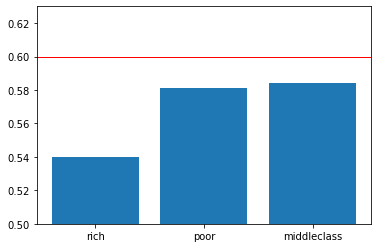

In [8]:
show = {}

count = df[["rich","middleclass","poor"]].sum()

for val in count.index:
    show[val] = (df[df[val]==1]["Y"].sum() / df[df[val]==1]["Y"].count())
ser = pd.Series(show,name="Wealth")
f, ax = plt.subplots(1)
ser = ser.sort_values(ascending=True)
plt.axhline(y=0.60,linewidth=1, color='red')
plt.bar(ser.index,ser)
ax.set_ylim(ymin=0.50)
print(ser.sort_values())

rich           4334
middleclass    5477
poor           2873
dtype: int64


Text(0.5, 1.0, 'Income')

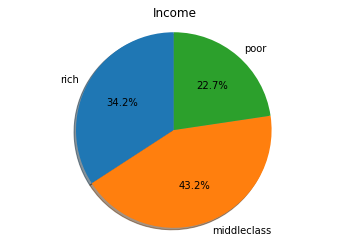

In [9]:
sizes = df[["rich","middleclass","poor"]].sum()
explode = (0, 0, 0)

fig1, ax1 = plt.subplots(1)
ax1.pie(sizes, explode=explode,labels=sizes.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print(df[["rich","middleclass","poor"]].sum())
plt.title("Income")

Text(0.5, 1.0, 'Age')

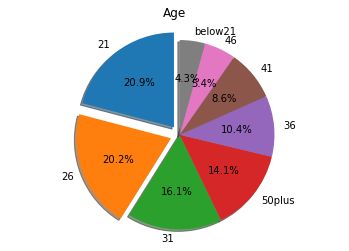

In [10]:
sizes = df["age"].value_counts()
explode = (0.1, 0.1, 0,0,0,0,0,0)

fig1, ax1 = plt.subplots(1)
ax1.pie(sizes, explode=explode,labels=sizes.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Age")

In [11]:
df["age0"] = df["age"].apply(lambda x: 1 if x =="below21" else 0)
df["age21"] = df["age"].apply(lambda x: 1 if x in ["21","26"] else 0)
df["age31"] = df["age"].apply(lambda x: 1 if x in ["31","36"] else 0)
df["age41"] = df["age"].apply(lambda x: 1 if x in ["41","46"] else 0)
df["age51"] = df["age"].apply(lambda x: 1 if x in ["50plus"] else 0)

50plus     0.508949
36         0.535254
31         0.546346
41         0.572736
46         0.575802
26         0.595936
21         0.598191
below21    0.634369
Name: Age, dtype: float64


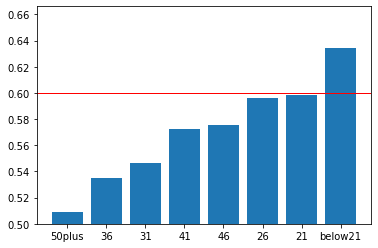

In [12]:
show = {}
for val in df["age"].unique():
    show[val]=(df[df["age"]==val]["Y"].sum() / df[df["age"]==val]["Y"].count())
ser = pd.Series(show,name="Age")
f, ax = plt.subplots(1)
ser = ser.sort_values(ascending=True)
plt.axhline(y=0.60,linewidth=1, color='red')
plt.bar(ser.index,ser)
ax.set_ylim(ymin=0.50)
print(ser.sort_values())

Potrebbe essere interessante capire come mai i 50plus sono il 14% ma performano così male

31, 26 e 21 rappresentano più della metà delle persone intervistate, ma 31 ha meno adesione, quindi guardiamo 26 e 21.

<BarContainer object of 9 artists>

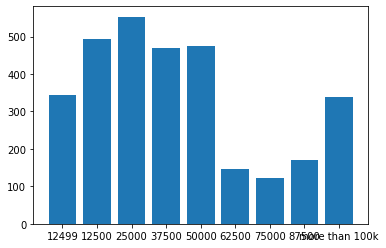

In [13]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["income"].value_counts().sort_index()
plt.bar(ser.index,ser)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

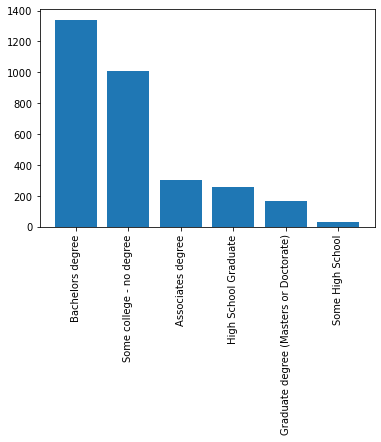

In [14]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["education"].value_counts()
plt.bar(ser.index,ser)
plt.xticks(rotation='vertical')

<BarContainer object of 2 artists>

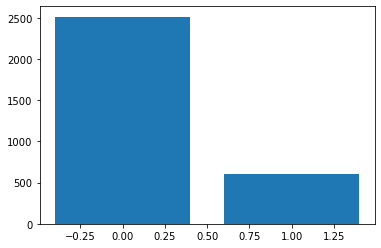

In [15]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["has_children"].value_counts()
plt.bar(ser.index,ser)

<BarContainer object of 5 artists>

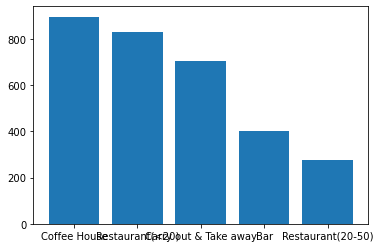

In [16]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["coupon"].value_counts()
plt.bar(ser.index,ser)

<BarContainer object of 5 artists>

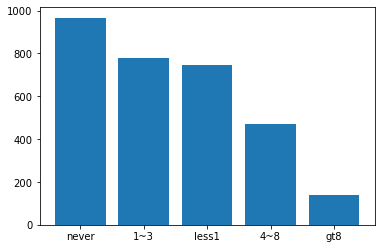

In [17]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["Bar"].value_counts()
plt.bar(ser.index,ser)

<BarContainer object of 5 artists>

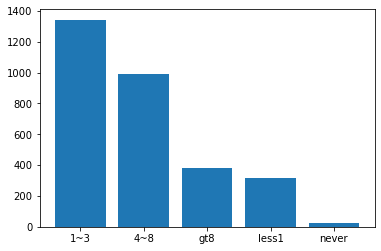

In [18]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["CarryAway"].value_counts()
plt.bar(ser.index,ser)

<BarContainer object of 5 artists>

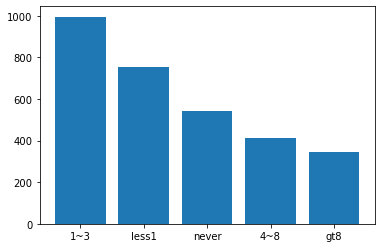

In [19]:
ser = df[df["age"].isin(["21","26"]) & df["Y"]==1]["CoffeeHouse"].value_counts()
plt.bar(ser.index,ser)

In [20]:
young = df[df["age"].isin(["21","26"])]

In [1]:
found = pd.pivot_table(df,index=["RestaurantLessThan20","coupon"],values="Y")
found

NameError: name 'pd' is not defined

In [22]:
df.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'rich', 'middleclass', 'poor',
       'age0', 'age21', 'age31', 'age41', 'age51'],
      dtype='object')

In [23]:
pd.pivot_table(df[df["age0"]==1],index=["passanger"],values="Y")

,Y
passanger,
Alone,0.611570
Friend(s),0.712121
Partner,0.596154


In [24]:
some = []
for col in ['rich', 'middleclass', 'poor','age0', 'age21', 'age31', 'age41', 'age51']:
  for col2 in ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
    'expiration', 'gender', 'maritalStatus', 'has_children',
    'Bar', 'CoffeeHouse',
    'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
    'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
    'direction_same', 'direction_opp']:
    found = pd.pivot_table(df[df[col]==1],index=[col2],values="Y")
    if not ((found[found["Y"]>0.70]).empty):
        some.append((col,(found[found["Y"]>0.70])))


######### CHECK DURING WINTER WHAT PLACE PREFERRED, AND CHECK AT WHAT TIME WHAT PLACE PREFERRED
######### CHECK POPULATION WITH CHILDREN WHAT PREFERS
######### 


In [25]:
some

[('rich',
                                Y
  coupon                         
  Carry out & Take away  0.702439),
 ('middleclass',
                                Y
  coupon                         
  Carry out & Take away  0.753196
  Restaurant(<20)        0.738294),
 ('middleclass',
                           Y
  Restaurant20To50          
  4~8               0.721591),
 ('poor',
                                Y
  coupon                         
  Carry out & Take away  0.751799),
 ('poor',
                           Y
  Restaurant20To50          
  4~8               0.812183),
 ('age0',
                    Y
  passanger          
  Friend(s)  0.712121),
 ('age0',
                     Y
  temperature         
  80           0.72242),
 ('age0',
               Y
  time          
  2PM   0.702703),
 ('age0',
                                Y
  coupon                         
  Carry out & Take away  0.728070
  Restaurant(<20)        0.734375),
 ('age0',
                      Y
  Coffee

<BarContainer object of 4 artists>

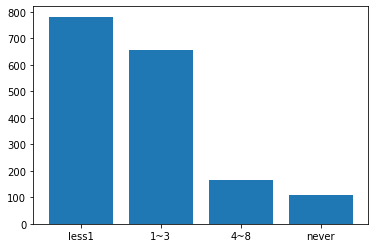

In [26]:
ser = df[df["income"]=="more than 100k"]["Restaurant20To50"].value_counts()
plt.bar(ser.index,ser)


Lets get a general look at the accepted the coupons

<BarContainer object of 5 artists>

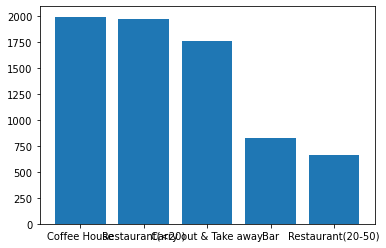

In [27]:
ser = df[df["Y"]==1]["coupon"].value_counts()
plt.bar(ser.index,ser)

In [28]:
df.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y', 'rich', 'middleclass', 'poor',
       'age0', 'age21', 'age31', 'age41', 'age51'],
      dtype='object')

In [29]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
rich                     int64
middleclass              int64
poor                     int64
age0                     int64
age21                    int64
age31                    int64
age41   

In [30]:
pd.pivot_table(df, values='Y', index=['maritalStatus'], aggfunc=np.mean)

,Y
maritalStatus,
Divorced,0.529070
Married partner,0.542941
Single,0.605850
Unmarried partner,0.561299
Widowed,0.476923


# Dataset balanced/unbalanced

In [31]:
df["Y"].value_counts()

1    7210
0    5474
Name: Y, dtype: int64

(array([5474., 7210.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

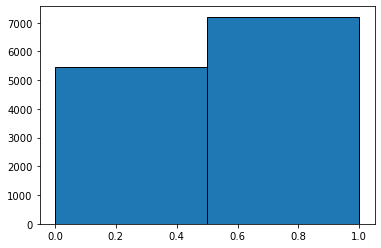

In [32]:
plt.hist(df["Y"],bins = 2, edgecolor = 'black')

In [33]:
df["Y"].value_counts()

1    7210
0    5474
Name: Y, dtype: int64

([<matplotlib.patches.Wedge at 0x1b62c35e0d0>,
 [Text(-0.2560024141966815, 1.1723748393434033, 'Used coupon'),
  Text(0.25600252396233425, -1.1723748153747227, 'Not used coupon')],
 [Text(-0.14933474161473087, 0.6838853229503186, '56.8%'),
  Text(0.14933480564469495, -0.6838853089685881, '43.2%')])

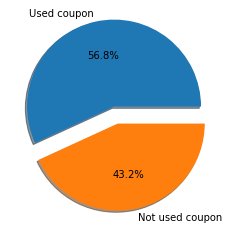

In [34]:
sizes = list(df["Y"].value_counts())
plt.pie(sizes, labels = ["Used coupon","Not used coupon"],explode = (0.1,0.1), autopct='%1.1f%%', shadow = True)

The dataset is balanced. This prevents us from oversampling/undersampling in order to obtain better accuracy. An imbalanced dataset can inject bias in the solution towards the majority class.

# Duplicated values checking and order Y

In [35]:
df.duplicated().sum()

74

In [36]:
df.set_index(df.pop('Y'), inplace=True)
df.reset_index(inplace=True)
df # colonna Y spostata all'inizio

,Y,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,direction_same,direction_opp,rich,middleclass,poor,age0,age21,age31,age41,age51
0,1,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,...,0,1,0,1,0,0,1,0,0,0
1,0,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,...,0,1,0,1,0,0,1,0,0,0
2,1,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,...,0,1,0,1,0,0,1,0,0,0
3,0,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,...,0,1,0,1,0,0,1,0,0,0
4,0,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,...,1,0,1,0,0,0,1,0,0,0
12680,1,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,...,0,1,1,0,0,0,1,0,0,0
12681,0,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,...,1,0,1,0,0,0,1,0,0,0
12682,0,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,...,0,1,1,0,0,0,1,0,0,0


# NaN values identification

In [37]:
df.isnull().any()

Y                       False
destination             False
passanger               False
weather                 False
temperature             False
time                    False
coupon                  False
expiration              False
gender                  False
age                     False
maritalStatus           False
has_children            False
education               False
occupation              False
income                  False
car                      True
Bar                      True
CoffeeHouse              True
CarryAway                True
RestaurantLessThan20     True
Restaurant20To50         True
toCoupon_GEQ5min        False
toCoupon_GEQ15min       False
toCoupon_GEQ25min       False
direction_same          False
direction_opp           False
rich                    False
middleclass             False
poor                    False
age0                    False
age21                   False
age31                   False
age41                   False
age51     

In [38]:
hist_list = []
for el in range(len(df.isnull().any())):
        hist_list.append(sum(df.iloc[:,el].isna()))
hist_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12576,
 107,
 217,
 151,
 130,
 189,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [39]:
col_names = list(df.columns)
col_names

['Y',
 'destination',
 'passanger',
 'weather',
 'temperature',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'has_children',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'toCoupon_GEQ5min',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'direction_opp',
 'rich',
 'middleclass',
 'poor',
 'age0',
 'age21',
 'age31',
 'age41',
 'age51']

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

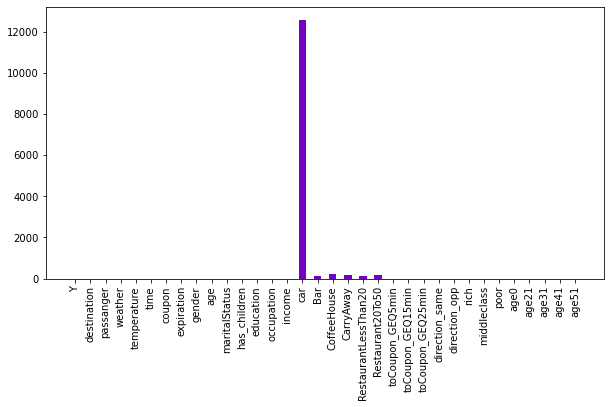

In [40]:
fig = plt.figure(figsize = (10, 5))
plt.bar(col_names, hist_list, color ='#7500c0',
        width = 0.5)
plt.xticks(rotation=90)

In [41]:
null_values = {}
for el in range(len(df.isnull().any())):
    if df.isnull().any()[el] == True:
        null_values[df.columns[el]] = sum(df.iloc[:,el].isna())
null_values #Number of NaN values per columns

{'car': 12576,
 'Bar': 107,
 'CoffeeHouse': 217,
 'CarryAway': 151,
 'RestaurantLessThan20': 130,
 'Restaurant20To50': 189}

In [42]:
null_values_perc = {}
for el in range(len(df.isnull().any())):
    if df.isnull().any()[el] == True:
        null_values_perc[df.columns[el]] = (sum(df.iloc[:,el].isna())/len(df)*100)
null_values_perc # Percentage of instances with null values

{'car': 99.14853358561967,
 'Bar': 0.8435824660990224,
 'CoffeeHouse': 1.7108167770419427,
 'CarryAway': 1.1904761904761905,
 'RestaurantLessThan20': 1.0249132765689057,
 'Restaurant20To50': 1.490066225165563}

"Car" variable contains NaN for almost all the instances, while all the other variables have a percentage of NaN values within 2%.

In [43]:
for el in null_values.keys():
    print(df.dtypes[el]) # all the variables with NaN are categorical

object
object
object
object
object
object


How to deal with Nan values? 
Ideas:
   1. using the mean for numerical features and the mode for categorical features (methods which dosen't prone for overfitting)
   2. back-fill and forward-fill (used for Time-series data)
   3. identificating NaN values as new categories (if the variables are categorical)
   4. deleting columns with too many NaNs (look at the "car" column. If the info we are deleting is not important that's a good solution)

In [44]:
df["car"].value_counts() # the few present data are evenly distributed with regard to the type

do not drive                                22
Mazda5                                      22
Scooter and motorcycle                      22
Car that is too old to install Onstar :D    21
crossover                                   21
Name: car, dtype: int64

In the following subsections there are two different implemented choices:
   * "car NaN" values identified with a new category and the other NaN with the mode
   * all the NaN are replaced with new categories (these new categories differ based on the feature they come from)
   * drop the "car column and then proxy the other columns with the mode
   * delete "car" column and rows with NaN

# Deleting unesuful column 

In [45]:
df.nunique()

Y                        2
destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
car                      5
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
direction_opp            2
rich                     2
middleclass              2
poor                     2
age0                     2
age21                    2
age31                    2
age41                    2
age51                    2
dtype: int64

In [46]:
del df['toCoupon_GEQ5min']

In [47]:
del df["age0"]
del df["age21"]
del df["age31"]
del df["age41"]
del df["age51"]

## FIRST NaN REPLACEMENT

In [48]:
new_df1 = df.copy()
new_df1['car'] = new_df1['car'].fillna('no_info_car')
new_df1['car'].value_counts()

no_info_car                                 12576
do not drive                                   22
Mazda5                                         22
Scooter and motorcycle                         22
Car that is too old to install Onstar :D       21
crossover                                      21
Name: car, dtype: int64

In [49]:
for el in list(null_values.keys())[1:]:
    new_df1[el] = new_df1[el].fillna(new_df1[el].mode()[0])

In [50]:
new_df1.isnull().any() #check no NaNs

Y                       False
destination             False
passanger               False
weather                 False
temperature             False
time                    False
coupon                  False
expiration              False
gender                  False
age                     False
maritalStatus           False
has_children            False
education               False
occupation              False
income                  False
car                     False
Bar                     False
CoffeeHouse             False
CarryAway               False
RestaurantLessThan20    False
Restaurant20To50        False
toCoupon_GEQ15min       False
toCoupon_GEQ25min       False
direction_same          False
direction_opp           False
rich                    False
middleclass             False
poor                    False
dtype: bool

## SECOND NaN REPLACEMENT

In [51]:
new_df2 = df.copy()
new_cat = ['no_info_car','no_info_bar','no_info_coffeehouse','no_info_carryaway','no_info_rest<20','no_info_rest20to50']
for el in range(len(new_cat)):
    new_df2[list(null_values.keys())[el]] = new_df2[list(null_values.keys())[el]].fillna(new_cat[el])


In [52]:
new_df2['Bar'].value_counts() #as example, check the Bar column

never          5197
less1          3482
1~3            2473
4~8            1076
gt8             349
no_info_bar     107
Name: Bar, dtype: int64

In [53]:
new_df2.isnull().any() #check no NaNs

Y                       False
destination             False
passanger               False
weather                 False
temperature             False
time                    False
coupon                  False
expiration              False
gender                  False
age                     False
maritalStatus           False
has_children            False
education               False
occupation              False
income                  False
car                     False
Bar                     False
CoffeeHouse             False
CarryAway               False
RestaurantLessThan20    False
Restaurant20To50        False
toCoupon_GEQ15min       False
toCoupon_GEQ25min       False
direction_same          False
direction_opp           False
rich                    False
middleclass             False
poor                    False
dtype: bool

## THIRD NaN REPLACEMENT

In [54]:
new_df3 = df.copy()
del new_df3['car']

In [55]:
new_df3['Bar'].value_counts()

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64

In [56]:
for el in list(null_values.keys())[1:]:
    new_df3[el] = new_df3[el].fillna(new_df3[el].mode()[0])

In [57]:
new_df3.isnull().any() #check no NaNs

Y                       False
destination             False
passanger               False
weather                 False
temperature             False
time                    False
coupon                  False
expiration              False
gender                  False
age                     False
maritalStatus           False
has_children            False
education               False
occupation              False
income                  False
Bar                     False
CoffeeHouse             False
CarryAway               False
RestaurantLessThan20    False
Restaurant20To50        False
toCoupon_GEQ15min       False
toCoupon_GEQ25min       False
direction_same          False
direction_opp           False
rich                    False
middleclass             False
poor                    False
dtype: bool

## FOURTH NaN REPLACEMENT

In [58]:
new_df4 = df.copy()
del new_df4['car']
new_df4 = new_df4.dropna(axis = "rows")
new_df4

,Y,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,rich,middleclass,poor
22,1,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,...,4~8,4~8,less1,0,0,0,1,1,0,0
23,0,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,...,4~8,4~8,less1,0,0,0,1,1,0,0
24,1,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,...,4~8,4~8,less1,0,0,0,1,1,0,0
25,0,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,...,4~8,4~8,less1,1,0,0,1,1,0,0
26,0,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,...,4~8,4~8,less1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,...,1~3,4~8,1~3,0,0,1,0,1,0,0
12680,1,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,...,1~3,4~8,1~3,0,0,0,1,1,0,0
12681,0,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,...,1~3,4~8,1~3,0,0,1,0,1,0,0
12682,0,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,...,1~3,4~8,1~3,1,1,0,1,1,0,0


# FEATURE ENGINEERING

First it is needed the split into train and test. This because the clustering and the tests cannot rely on test data we will use to evaluate the model.

In [59]:
cleaned = new_df1
X, y = cleaned.iloc[:,1:].values, cleaned.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76, stratify = y) # 80% training and 20% test

## KMODES, CHI-SQUARE TESTS, RELEVANCE OF CATEGORIES

In [60]:
new_df1_train = pd.DataFrame(X_train, columns = cleaned.columns[1:])
new_df1_test = pd.DataFrame(X_test, columns = cleaned.columns[1:])

### RELEVANCE OF CATEGORIES

Here we want to identify those categories which are not properly represented in our dataset, according to a given threshold, fixing this threshold equal to 1% of the length of the dataset. Values of these categories can be then identified as null values or split equally to the remaining categories. In this way, we can decrease the dimensionality of the dataset.

In [61]:
threshold = len(X_train)/100
int(threshold)

101

In [62]:
no_representative = []
for el in new_df1_train.columns:
    for i in range(len(new_df1_train[el].value_counts())):
        if list(new_df1_train[el].value_counts())[i] < threshold:
            no_representative.append([el,new_df1_train[el].value_counts().index[i],list(new_df1_train[el].value_counts())[i]])
no_representative        

[['education', 'Some High School', 71],
 ['occupation', 'Production Occupations', 96],
 ['occupation', 'Building & Grounds Cleaning & Maintenance', 35],
 ['occupation', 'Farming Fishing & Forestry', 33],
 ['car', 'do not drive', 18],
 ['car', 'Mazda5', 18],
 ['car', 'Scooter and motorcycle', 15],
 ['car', 'crossover', 15],
 ['car', 'Car that is too old to install Onstar :D', 14]]

"Car" categories are under-represented. We may delete the column, but the Chi-Square test (coming below) suggests the relevance of this category on the output. What to do so? 

In [63]:
# Here we try to delete the "car" column.
del new_df1_train["car"]
del new_df1_test["car"]

In [64]:
no_representative = []
for el in new_df1_train.columns:
    for i in range(len(new_df1_train[el].value_counts())):
        if list(new_df1_train[el].value_counts())[i] < threshold:
            no_representative.append([el,new_df1_train[el].value_counts().index[i],list(new_df1_train[el].value_counts())[i]])
no_representative   

[['education', 'Some High School', 71],
 ['occupation', 'Production Occupations', 96],
 ['occupation', 'Building & Grounds Cleaning & Maintenance', 35],
 ['occupation', 'Farming Fishing & Forestry', 33]]

Next, we decide to set the "occupation" categories reported in "no_representative" to a new "no_info_occupation" column.

In [65]:
forbidden_occ_cat = []
for el in no_representative:
    if el[0] == 'occupation':
        forbidden_occ_cat.append(el[1])
forbidden_occ_cat

['Production Occupations',
 'Building & Grounds Cleaning & Maintenance',
 'Farming Fishing & Forestry']

In [66]:
new_occupation = []
for el in list(new_df1_train["occupation"]):
    if el in forbidden_occ_cat:
        new_occupation.append("no_info_occupation")
    else:
        new_occupation.append(el)
new_df1_train["occupation"] = new_occupation
new_occupation_test = []
for el in list(new_df1_test["occupation"]):
    if el in forbidden_occ_cat:
        new_occupation_test.append("no_info_occupation")
    else:
        new_occupation_test.append(el)
new_df1_test["occupation"] = new_occupation_test

In [67]:
no_representative = []
for el in new_df1_train.columns:
    for i in range(len(new_df1_train[el].value_counts())):
        if list(new_df1_train[el].value_counts())[i] < threshold:
            no_representative.append([el,new_df1_train[el].value_counts().index[i],list(new_df1_train[el].value_counts())[i]])
no_representative   

[['education', 'Some High School', 71]]

We decide to keep this category.

### KMODES

Best run was number 1
Best run was number 2
Best run was number 1
Best run was number 3
Best run was number 5


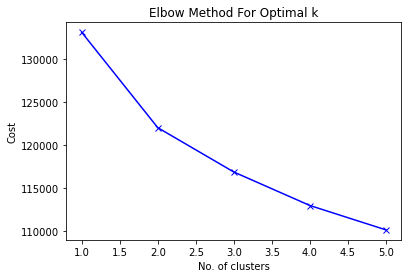

In [68]:
# Elbow curve to find optimal K
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1,n_jobs=-1)
    kmode.fit_predict(X_train)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


In [69]:
# Building the model with 4 clusters
kmode = KModes(n_clusters=4, init = "random", n_init = 5, verbose=1,n_jobs=-1)
clusters = kmode.fit_predict(X_train)
clusters

Best run was number 3


array([2, 0, 3, ..., 1, 1, 0], dtype=uint16)

In [70]:
test_cl = kmode.predict(X_test)

In [71]:
new_df1_train.insert(0, "Cluster", clusters, True) 
new_df1_test.insert(0, "Cluster", test_cl, True)

### CHI-SQUARE TESTS

In [72]:
new_df = pd.concat([pd.DataFrame(y_train,columns=["Y"]),new_df1_train],axis=1)
new_df_test = pd.concat([pd.DataFrame(y_test,columns=["Y"]),new_df1_test],axis=1)
target = list(np.unique(y_train))
independent = []
for el in new_df.columns[1:]:
    table=pd.crosstab(new_df["Y"],new_df[el])
    stat, p, dof, expected = chi2_contingency(table)
    if stat < scipy.stats.chi2.ppf(1-.05, df=dof) and np.all(table.values > 5):
        independent.append(el)
        print(stat)
print(scipy.stats.chi2.ppf(1-.01, df=dof))
independent

0.8344442991204987
0.8344442991204988
0.7611688116099755
6.6348966010212145


['direction_same', 'direction_opp', 'poor']

Is it reasonable to drop these variables?

In [73]:
# dropping correposnding features in tr and test set
new_df_test.drop(independent,1,inplace = True)
new_df.drop(independent,1,inplace = True)

## ONEHOT ENCODING OF CATEGORICAL VARIABLES

In [74]:
new_df = pd.concat([pd.DataFrame(y_train,columns=["Y"]),new_df1_train],axis=1)
new_df_test = pd.concat([pd.DataFrame(y_test,columns=["Y"]),new_df1_test],axis=1)
target = list(np.unique(y_train))

## First case (to match "First NaN replacement")

In [75]:
# pref = []
# dum = sorted(list(new_df1['destination'].unique()))
# for i in dum:
#    pref.append('%s-%s'% (new_df1.columns[1], i))
# pref

In [76]:
# prova = pd.DataFrame()
# for el in new_df1.columns[1:]:
#    pref = []
#    dum = sorted(list(new_df1[el].unique()))
#    for i in dum:
#        pref.append('%s_%s'% (el, i))
#    prova = pd.concat([prova,pd.get_dummies(new_df1[el],prefix = pref)],axis=1)
# prova.insert(0,"Y",df["Y"])
# prova

In [77]:
prova = pd.DataFrame()
for el in new_df.columns[1:]:
    prova = pd.concat([prova,pd.get_dummies(new_df[el], prefix = el, drop_first = True)],axis=1)
prova.insert(0,"Y",new_df["Y"])
prova_test = pd.DataFrame()
for el in new_df_test.columns[1:]:
    prova_test = pd.concat([prova_test,pd.get_dummies(new_df_test[el], prefix = el, drop_first = True)],axis=1)
prova_test.insert(0,"Y",new_df_test["Y"])

In [78]:
prova

,Y,Cluster_1,Cluster_2,Cluster_3,destination_No Urgent Place,destination_Work,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,...,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_1,toCoupon_GEQ25min_1,direction_same_1,direction_opp_1,rich_1,middleclass_1,poor_1
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,0,0,0,0,1,0,0,0,1,0,...,0,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
10143,1,1,0,0,1,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,1
10144,1,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
10145,0,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [79]:
LA.matrix_rank(prova.iloc[:,1:]) 

92

In [80]:
a = prova.iloc[:,1:].corr()>0.7
a

,Cluster_1,Cluster_2,Cluster_3,destination_No Urgent Place,destination_Work,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,weather_Sunny,...,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_1,toCoupon_GEQ25min_1,direction_same_1,direction_opp_1,rich_1,middleclass_1,poor_1
Cluster_1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Cluster_2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Cluster_3,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
destination_No Urgent Place,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
destination_Work,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
direction_same_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
direction_opp_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
rich_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
middleclass_1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [81]:
indexes = []
for el in a.columns:
    for i in a.columns:
        if a.loc[el,i] == True and el != i:
            indexes.append([el,i])
indexes


[['destination_Work', 'time_7AM'],
 ['time_7AM', 'destination_Work'],
 ['income_12500', 'poor_1'],
 ['poor_1', 'income_12500']]

In [82]:
for el in indexes:
    if [el[1],el[0]] in indexes:
        indexes.remove([el[0],el[1]])
indexes

[['time_7AM', 'destination_Work'], ['poor_1', 'income_12500']]

In [83]:
# drop one of the columns on the previous couple of lists because they have the same information
del prova['time_7AM']
del prova_test['time_7AM']

In [84]:
del prova['poor_1']
del prova_test['poor_1']

The rank of the matrix is the largest numbers of linearly independent columns/rows, therefore it is at most equal to the min(n_columns,n_rows). It represents the number of rows/columns which are able to carry out the information about all the rows/columns. If the rank is smaller than the number of rows/columns, this means that the number of rows/columns identified by the rank can be linearly combined and reproduced the other not-considered column. The rank gives as hint about multi-colinearity problem ("Spearman correlation" and "Chi-square test" problem since variables are only categorical, but check also the correlogram!).

In [85]:
# vif_data = pd.DataFrame()
# vif_data['features'] = prova.iloc[:,1:].columns
# calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(prova.iloc[:,1:].values, i)
#                          for i in range(len(prova.iloc[:,1:].columns))]
# w = vif_data.sort_values('VIF', ascending=False, ignore_index = True)["VIF"]>10
# w

In [86]:
# ign_feat = []
# vif_data = pd.DataFrame()
# vif_data['features'] = prova.iloc[:,1:].columns
# calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(prova.iloc[:,1:].values, i)
#                        for i in range(len(prova.iloc[:,1:].columns))]
# while vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"VIF"] > 10:
#    ign_feat.append(vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"])
#    del prova[vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"]]
#    vif_data = pd.DataFrame()
#    vif_data['features'] = prova.iloc[:,1:].columns
    # calculating VIF for each feature
#    vif_data["VIF"] = [variance_inflation_factor(prova.iloc[:,1:].values, i)
#                           for i in range(len(prova.iloc[:,1:].columns))]
# ign_feat

## Third case (to match "third NaN replacemnt")

In [87]:
#new_df3

In [88]:
#target = list(np.unique(new_df3["Y"]))
#independent = []
#for el in new_df3.columns[1:]:
#    table=pd.crosstab(new_df3["Y"],new_df3[el])
#    stat, p, dof, expected = chi2_contingency(table)
#    if stat < scipy.stats.chi2.ppf(1-.05, df=dof):
#        independent.append(el)
#independent #HI-SQUARE TEST

In [89]:
#prova3 = pd.DataFrame()
#for el in new_df3.columns[1:]:
#    prova3 = pd.concat([prova3,pd.get_dummies(new_df3[el], prefix = el, drop_first = True)],axis=1)
#prova3.insert(0,"Y",df["Y"])
#prova3

In [90]:
#cleaned = prova3

## Fourth case

In [91]:
#new_df4

In [92]:
#import scipy.stats
#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#target = list(np.unique(new_df4["Y"]))
#independent = []
#for el in new_df4.columns[1:]:
#    table=pd.crosstab(new_df4["Y"],new_df4[el])
#    stat, p, dof, expected = chi2_contingency(table)
#    if stat < scipy.stats.chi2.ppf(1-.05, df=dof):
#        independent.append(el)
#        del new_df4[el]
#independent

In [93]:
#new_df4

In [94]:
#prova4 = pd.DataFrame()
#for el in new_df4.columns[1:]:
#    prova4 = pd.concat([prova4,pd.get_dummies(new_df4[el], prefix = el, drop_first = True)],axis=1)
#prova4.insert(0,"Y",df["Y"])
#prova4

In [95]:
#bho = prova4

# TREE ANALYSIS

In [96]:
# ign_feat = []
# vif_data = pd.DataFrame()
# vif_data['features'] = prova.iloc[:,1:].columns
# calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(prova.iloc[:,1:].values, i)
#                        for i in range(len(prova.iloc[:,1:].columns))]
# while vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"VIF"] > 5:
#    ign_feat.append(vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"])
#    del prova[vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"]]
#    vif_data = pd.DataFrame()
#    vif_data['features'] = prova.iloc[:,1:].columns
    # calculating VIF for each feature
#    vif_data["VIF"] = [variance_inflation_factor(prova.iloc[:,1:].values, i)
#                          for i in range(len(prova.iloc[:,1:].columns))]
# ign_feat

In [97]:
# OVERSAMPLING RANDOMLY
#summarize class distribution
# print(Counter(y))
# define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
#X_over, y_over = oversample.fit_resample(X, y) #now are oversampled
# summarize class distribution
#print(Counter(y))

In [98]:
# UNDERSAMPLING WITH NEAR_MISS -> DOESN'T WORK!
# summarize class distribution
counter = Counter(y)
counter = dict(counter)
counter[1]=counter[1]/(cleaned["Y"].value_counts()[0]+cleaned["Y"].value_counts()[1])
counter[0]=counter[0]/(cleaned["Y"].value_counts()[0]+cleaned["Y"].value_counts()[1])
counter
# print(counter)
# define the undersampling method
# undersample = NearMiss(version=3, n_neighbors_ver3=3)
# transform the dataset
# X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
# counter = Counter(y)
# print(counter)

{1: 0.5684326710816777, 0: 0.4315673289183223}

In [99]:
# RUNTIME PROBLEM WITH CONDENSED-NN
# summarize class distribution
# counter = Counter(y)
# print(counter)
# define the undersampling method
# undersample = CondensedNearestNeighbour(n_neighbors=1)
# transform the dataset
# X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
# counter = Counter(y)
# print(counter)

Stratify plays a key role, without it the whole process loses 1/1,5% accuracy. Therefore, the importance to obtain a perfectly balanced dataset, because it's the cross-validation estimate which gives the real accuracy of the estimator. Balancing the dataset, the accuracy might rise (using stratifiedKFold might add something too).

In [100]:
# OVERSAMPLING RANDOMLY
#summarize class distribution
# print(Counter(y_train))
# define oversampling strategy
#oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
#X_over, y_over = oversample.fit_resample(X_train, y_train) #now are oversampled
# summarize class distribution
#print(Counter(y_over))

In [101]:
# UNDERSAMPLING WITH NEAR_MISS 
# summarize class distribution
counter = Counter(y)
counter = dict(counter)
counter[1]=counter[1]/(cleaned["Y"].value_counts()[0]+cleaned["Y"].value_counts()[1])
counter[0]=counter[0]/(cleaned["Y"].value_counts()[0]+cleaned["Y"].value_counts()[1])
print(counter)
# define the undersampling method
# undersample = NearMiss(version=3, n_neighbors_ver3=3)
# transform the dataset
# X_train_und, y_train_und = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
# counter = Counter(y)
# print(counter)

{1: 0.5684326710816777, 0: 0.4315673289183223}


In [102]:
prova.shape

(10147, 95)

In [103]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train) #folds stratified

5

In [104]:
# multicollinearity in the train set
#r = pd.DataFrame(X_train, columns = list(prova.columns)[1:])
#ign_feat = []
#vif_data = pd.DataFrame()
#vif_data['features'] = r.iloc[:,1:].columns
# calculating VIF for each feature
#vif_data["VIF"] = [variance_inflation_factor(r.iloc[:,1:].values, i)
#                       for i in range(len(r.iloc[:,1:].columns))]
#while vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"VIF"] > 5:
#    ign_feat.append(vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"])
#    del r[vif_data.sort_values('VIF', ascending=False,ignore_index = True).loc[0,"features"]]
#    vif_data = pd.DataFrame()
#    vif_data['features'] = r.iloc[:,1:].columns
    # calculating VIF for each feature
#    vif_data["VIF"] = [variance_inflation_factor(r.iloc[:,1:].values, i)
#                           for i in range(len(r.iloc[:,1:].columns))]
#ign_feat

In [105]:
# dropping correposnding features in test set
#p = pd.DataFrame(X_test, columns = list(prova.columns)[1:])
#p.drop(ign_feat,1,inplace = True) 

In [106]:
X_train, y_train = prova.iloc[:,1:].values,prova.iloc[:,:1].values
X_test,y_test = prova_test.iloc[:,1:].values,prova_test.iloc[:,:1].values
X,y = pd.concat([prova.iloc[:,1:],prova_test.iloc[:,1:]],axis=0),pd.concat([prova.iloc[:,:1],prova_test.iloc[:,:1]],axis=0)

In [107]:
# we can change also criterion
clf = tree.DecisionTreeClassifier(random_state=76)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6980685849428458

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1095
           1       0.73      0.73      0.73      1442

    accuracy                           0.70      2537
   macro avg       0.69      0.69      0.69      2537
weighted avg       0.70      0.70      0.70      2537



In [109]:
int(clf.tree_.node_count), int(clf.tree_.max_depth)

(5171, 28)

In [110]:
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(clf, X_train, y_train, train_sizes=sizes, cv=skf)
train_size, train_score, val_score

(array([1000, 3000, 5000, 7000]),
 array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [0.99933333, 0.99933333, 0.99966667, 0.99966667, 0.99966667],
        [0.9996    , 0.9994    , 0.9992    , 0.9992    , 0.9992    ],
        [0.99914286, 0.99871429, 0.99885714, 0.999     , 0.99928571]]),
 array([[0.60246305, 0.57980296, 0.58698866, 0.60128142, 0.58107442],
        [0.65123153, 0.62660099, 0.62888122, 0.63824544, 0.64070971],
        [0.66009852, 0.65566502, 0.6461311 , 0.65105964, 0.6673238 ],
        [0.66945813, 0.69704433, 0.68358797, 0.67718088, 0.68358797]]))

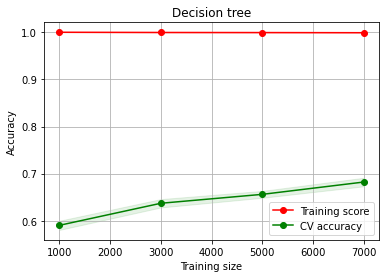

In [111]:
plt.title('Decision tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [112]:
list(np.round(np.mean(val_score, 1), decimals=2))

[0.59, 0.64, 0.66, 0.68]

No bias and large variance error -> Bagging and Random Forest!

## TUNING MAX_DEPTH

In [113]:
depths = range(1,40)
train_score, val_score = validation_curve(DecisionTreeClassifier(), X_train, y_train, param_name = 'max_depth', param_range = depths, cv=skf,n_jobs=-1)
gini_train_mean = []
gini_val_mean = []
for el in range(len(train_score)):
    gini_train_mean.append(train_score[el].mean())
    gini_val_mean.append(val_score[el].mean())

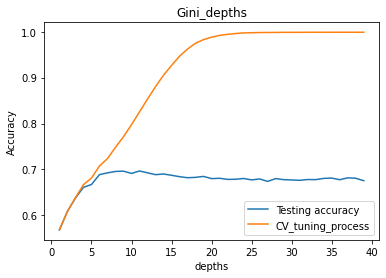

In [114]:
plt.title('Gini_depths')
plt.plot(depths, np.mean(val_score, 1), label='Testing accuracy')
plt.plot(depths, np.mean(train_score, 1), label='CV_tuning_process')
plt.legend()
plt.xlabel('depths')
plt.ylabel('Accuracy')
plt.show()

In [115]:
depths = range(1,50)
entropy_train_score, entropy_val_score = validation_curve(tree.DecisionTreeClassifier(criterion = "entropy"), X_train, y_train, param_name = 'max_depth', param_range = depths, cv=skf,n_jobs=-1)
entropy_train_mean = []
entropy_val_mean = []
for el in range(len(train_score)):
    entropy_train_mean.append(entropy_train_score[el].mean())
    entropy_val_mean.append(entropy_val_score[el].mean())

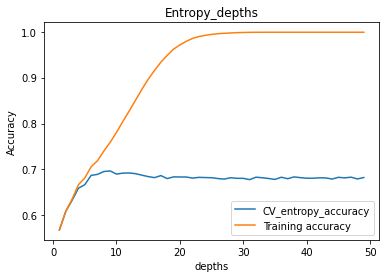

In [116]:
plt.title('Entropy_depths')
plt.plot(depths, np.mean(entropy_val_score, 1), label='CV_entropy_accuracy')
plt.plot(depths, np.mean(entropy_train_score, 1), label='Training accuracy')
plt.legend()
plt.xlabel('depths')
plt.ylabel('Accuracy')
plt.show()

In [117]:
max(entropy_val_mean) #slightly greater than gini criterion

0.6968560309016794

Automated selection of max_depth and criterion using GridSearchCV

In [118]:
k_grid = {'max_depth': range(1, 40),'criterion':('gini','entropy')}
learner = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=k_grid, cv=skf, return_train_score=True,n_jobs=-1)
learner.fit(X_train, y_train)
learner.best_params_, learner.best_score_ # to check previous result

({'criterion': 'gini', 'max_depth': 11}, 0.6976436255574952)

In [119]:
model = learner.best_estimator_
scores = cross_validate(model, X, y, cv=skf,return_train_score=True)
scores['train_score'].mean(),scores["test_score"].mean()

(0.8208176774221467, 0.7061655324540648)

Now we go through all the possible depths using CV to compare our selected model with the other possible depths to understand if it works well also in the previously unkonwn fold. 

In [120]:
train_perf = []
test_perf = []
depths = []
for max_d in range(1,40):
   scores = cross_validate(tree.DecisionTreeClassifier(criterion = "entropy",max_depth = max_d), X, y, cv=skf,return_train_score=True,n_jobs=-1) 
   print('The Training Accuracy for max_depth {} is:'.format(max_d), scores['train_score'].mean())
   train_perf.append(scores['train_score'].mean())
   print('The test Accuracy for max_depth {} is:'.format(max_d),scores["test_score"].mean() )
   test_perf.append(scores['test_score'].mean())
   depths.append(max_d)
   print('')

The Training Accuracy for max_depth 1 is: 0.5684326719649221
The test Accuracy for max_depth 1 is: 0.5684326852177677

The Training Accuracy for max_depth 2 is: 0.6114002426063317
The test Accuracy for max_depth 2 is: 0.6114010437325686

The Training Accuracy for max_depth 3 is: 0.6368653011996804
The test Accuracy for max_depth 3 is: 0.6354462472753408

The Training Accuracy for max_depth 4 is: 0.6661935667096908
The test Accuracy for max_depth 4 is: 0.6620156696662269

The Training Accuracy for max_depth 5 is: 0.677112858015163
The test Accuracy for max_depth 5 is: 0.6710031284621669

The Training Accuracy for max_depth 6 is: 0.7049431729609429
The test Accuracy for max_depth 6 is: 0.6970990227907723

The Training Accuracy for max_depth 7 is: 0.715251494788532
The test Accuracy for max_depth 7 is: 0.6963889638399013

The Training Accuracy for max_depth 8 is: 0.7354934784252878
The test Accuracy for max_depth 8 is: 0.7049039514864548

The Training Accuracy for max_depth 9 is: 0.753094

Text(0, 0.5, 'Accuracy')

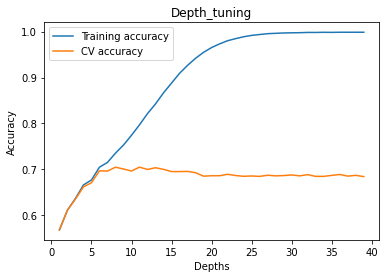

In [121]:
plt.title("Depth_tuning")
plt.plot(depths,train_perf,label = "Training accuracy")
plt.plot(depths,test_perf,label = "CV accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [122]:
# we can change also criterion
clf = model

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7083169097359086

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1095
           1       0.73      0.77      0.75      1442

    accuracy                           0.71      2537
   macro avg       0.70      0.70      0.70      2537
weighted avg       0.71      0.71      0.71      2537



Precision (how many positive identification correct?) and recall (what proportion of true positive correctly identified?) are here given.
(Note: Consider the values according the proportion of 1/0 in our dataset: a predictor without clues would classify following these proportions: 0.56 for 1, 0.43 for 0), based on this fact we should evaluate our metrics).

Here what it would have been the best for our specific split.

In [124]:
train_perf = []
test_perf = []
depths = []
for max_d in range(1,28):
   model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=max_d, random_state=22)
   model.fit(X_train, y_train)
   print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
   train_perf.append(model.score(X_train, y_train))
   print('The test Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
   test_perf.append(model.score(X_test,y_test))
   depths.append(max_d)
   print('') #8 should be the best one, given the prvious result

The Training Accuracy for max_depth 1 is: 0.5684438750369567
The test Accuracy for max_depth 1 is: 0.5683878596767836

The Training Accuracy for max_depth 2 is: 0.6087513550803193
The test Accuracy for max_depth 2 is: 0.6219944816712653

The Training Accuracy for max_depth 3 is: 0.6390066029368286
The test Accuracy for max_depth 3 is: 0.6353961371698857

The Training Accuracy for max_depth 4 is: 0.669458953385237
The test Accuracy for max_depth 4 is: 0.668506109578242

The Training Accuracy for max_depth 5 is: 0.6792155316842416
The test Accuracy for max_depth 5 is: 0.6744186046511628

The Training Accuracy for max_depth 6 is: 0.708189612693407
The test Accuracy for max_depth 6 is: 0.7008277493102089

The Training Accuracy for max_depth 7 is: 0.715482408593673
The test Accuracy for max_depth 7 is: 0.6941269215608987

The Training Accuracy for max_depth 8 is: 0.7384448605499162
The test Accuracy for max_depth 8 is: 0.7079227433977139

The Training Accuracy for max_depth 9 is: 0.75539568

Text(0, 0.5, 'Accuracy')

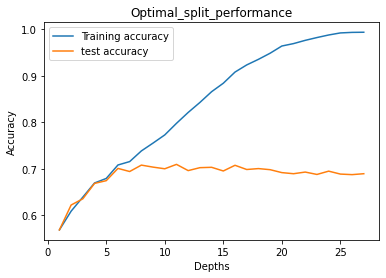

In [125]:
plt.title("Optimal_split_performance")
plt.plot(depths,train_perf,label = "Training accuracy")
plt.plot(depths,test_perf,label = "test accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

The performance on our initial split is instead 0.70, improved performance respect the starting point.

### TRYING TO TUNE MORE PARAMTERS

In [126]:
k_grid = {'max_depth': range(1, 40),'min_samples_leaf': range(1,10,3),'criterion':('gini','entropy')}
learner = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=9), param_grid=k_grid, cv=skf, return_train_score=True,n_jobs=-1)
learner.fit(X_train, y_train)
learner.best_params_, learner.best_score_ # to check previous result

({'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1},
 0.6966587437816683)

In [127]:
model = learner.best_estimator_
scores = cross_validate(model, X, y, cv=skf,return_train_score=True)
scores['train_score'].mean(),scores["test_score"].mean() #these are the performances on the entire dataset with cross-validate estimates

(0.7530944174633672, 0.7012774968323698)

The performance decreases and the overfitting increases.

In [128]:
train_perf = []
test_perf = []
depths = []
for max_d in range(1,40):
   scores = cross_validate(tree.DecisionTreeClassifier(criterion='entropy',max_depth = max_d, min_samples_leaf=7), X, y, cv=skf,return_train_score=True) 
   print('The Training Accuracy for max_depth {} is:'.format(max_d), scores['train_score'].mean())
   train_perf.append(scores['train_score'].mean())
   print('The test Accuracy for max_depth {} is:'.format(max_d),scores["test_score"].mean() )
   test_perf.append(scores['test_score'].mean())
   depths.append(max_d)
   print('') #in the outside cv 6 is the best

The Training Accuracy for max_depth 1 is: 0.5684326719649221
The test Accuracy for max_depth 1 is: 0.5684326852177677

The Training Accuracy for max_depth 2 is: 0.6114002426063317
The test Accuracy for max_depth 2 is: 0.6114010437325686

The Training Accuracy for max_depth 3 is: 0.6368653011996804
The test Accuracy for max_depth 3 is: 0.6354462472753408

The Training Accuracy for max_depth 4 is: 0.666154146191311
The test Accuracy for max_depth 4 is: 0.6621733362015048

The Training Accuracy for max_depth 5 is: 0.6770537233530328
The test Accuracy for max_depth 5 is: 0.6710030662908202

The Training Accuracy for max_depth 6 is: 0.7037803006875011
The test Accuracy for max_depth 6 is: 0.6963106279430361

The Training Accuracy for max_depth 7 is: 0.713832393030182
The test Accuracy for max_depth 7 is: 0.6945757986842056

The Training Accuracy for max_depth 8 is: 0.7322216628023707
The test Accuracy for max_depth 8 is: 0.7030909417591257

The Training Accuracy for max_depth 9 is: 0.745900

Text(0, 0.5, 'Accuracy')

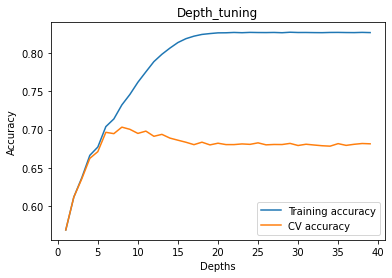

In [129]:
plt.title("Depth_tuning")
plt.plot(depths,train_perf,label = "Training accuracy")
plt.plot(depths,test_perf,label = "CV accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [130]:
max(test_perf)

0.7030909417591257

In [131]:
# we can change also criterion
clf = model

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7047694126921561

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1095
           1       0.73      0.76      0.75      1442

    accuracy                           0.70      2537
   macro avg       0.70      0.70      0.70      2537
weighted avg       0.70      0.70      0.70      2537



In [133]:
cohen_kappa_score(y_test, y_pred)

0.39381943777631956

Both the criterion give as best max_depth = 8. The Entropy criterion seems to perform better, therefore we will try to go on with this criterion. Here best performance given our split

In [134]:
train_perf = []
test_perf = []
depths = []
for max_d in range(1,28):
   model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=max_d, min_samples_leaf = 7, random_state=22)
   model.fit(X_train, y_train)
   print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
   train_perf.append(model.score(X_train, y_train))
   print('The test Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
   test_perf.append(model.score(X_test,y_test))
   depths.append(max_d)
   print('') #8 should be the best one, given the prvious result

The Training Accuracy for max_depth 1 is: 0.5684438750369567
The test Accuracy for max_depth 1 is: 0.5683878596767836

The Training Accuracy for max_depth 2 is: 0.6087513550803193
The test Accuracy for max_depth 2 is: 0.6219944816712653

The Training Accuracy for max_depth 3 is: 0.6390066029368286
The test Accuracy for max_depth 3 is: 0.6353961371698857

The Training Accuracy for max_depth 4 is: 0.669458953385237
The test Accuracy for max_depth 4 is: 0.668506109578242

The Training Accuracy for max_depth 5 is: 0.6794126342761407
The test Accuracy for max_depth 5 is: 0.6736302719747733

The Training Accuracy for max_depth 6 is: 0.7065142406622648
The test Accuracy for max_depth 6 is: 0.7000394166338195

The Training Accuracy for max_depth 7 is: 0.7136099339706317
The test Accuracy for max_depth 7 is: 0.693732755222704

The Training Accuracy for max_depth 8 is: 0.7337143983443383
The test Accuracy for max_depth 8 is: 0.7075285770595191

The Training Accuracy for max_depth 9 is: 0.7468217

Text(0, 0.5, 'Accuracy')

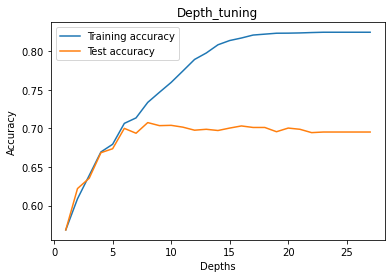

In [135]:
plt.title("Depth_tuning")
plt.plot(depths,train_perf,label = "Training accuracy")
plt.plot(depths,test_perf,label = "Test accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [136]:
max(test_perf) #max perf

0.7075285770595191

In [137]:
opt = depths[test_perf.index(max(test_perf))] #optimal depth
opt

8

# BAGGING

In [138]:
clf_tuned = tree.DecisionTreeClassifier(max_depth = 8,criterion='entropy')

# Train Decision Tree Classifer
clf_tuned = clf_tuned.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_tuned.predict(X_test)

In [139]:
accuracy_score(y_test, y_pred)


0.706346078044935

In [140]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
bag_lrn = BaggingClassifier(base_estimator=clf, n_estimators=1)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(bag_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

In [141]:
bag_lrn = bag_lrn.fit(X_train, y_train)
y_p = bag_lrn.predict(X_test)
y_t = bag_lrn.predict(X_train)
print(accuracy_score(y_test, y_p))
print(accuracy_score(y_train, y_t)) #full tree accuracy, test score high but overfitting too

0.6689002759164367
0.8728688282250912


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [142]:
cohen_kappa_score(y_test, y_p)

0.3245824992615375

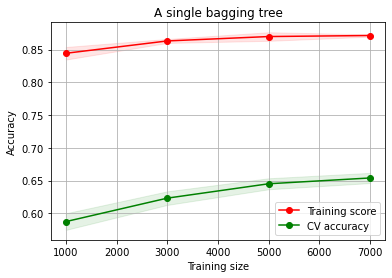

In [143]:
plt.title('A single bagging tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

1 estimator considered, now we are going ot increase the number.

In [144]:
# Now with 10 trees
tree_lrn = DecisionTreeClassifier(criterion = "entropy")
bag_lrn = BaggingClassifier(base_estimator=tree_lrn, n_estimators=10)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(bag_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

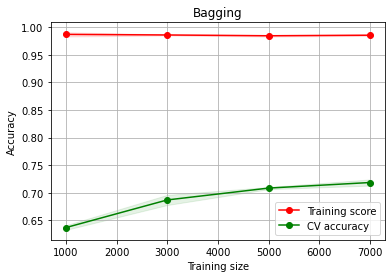

In [145]:
plt.title('Bagging')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

Same training error, but CV accuracy increases of 5%.

In [146]:
# Now with 20 trees
tree_lrn = DecisionTreeClassifier(criterion = "entropy")
bag_lrn = BaggingClassifier(base_estimator=tree_lrn, n_estimators=20)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(bag_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

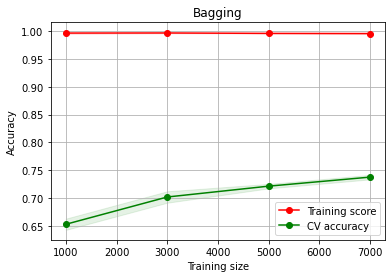

In [147]:
plt.title('Bagging')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

With 20 estimators we are approaching 0.75 Cv_accuracy!

In [148]:
bag_trains = []
bag_test = []
depths = range(5,25)
for el in depths:
    n_estimators = [1,10,20,40]
    tree_lrn = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = el,random_state=78)
    bag_train_score, bag_val_score = validation_curve(BaggingClassifier(base_estimator = tree_lrn), X_train, y_train, param_name='n_estimators', param_range=n_estimators, cv=skf,n_jobs=-1)
    bag_trains.append(bag_train_score), bag_test.append(bag_val_score)

In [149]:
mean_bag_train = []
for el in bag_trains:
    cross = []
    for i in el:
        cross.append(np.mean(i))
    mean_bag_train.append(cross)
tr_est1 = []
tr_est10 = []
tr_est20 = []
tr_est40 = []
for el in mean_bag_train:
    tr_est1.append(el[0])
    tr_est10.append(el[1])
    tr_est20.append(el[2])
    tr_est40.append(el[3])


In [150]:
mean_bag_test = []
for el in bag_test:
    cross = []
    for i in el:
        cross.append(np.mean(i))
    mean_bag_test.append(cross)
test_est1 = []
test_est10 = []
test_est20 = []
test_est40 = []
for el in mean_bag_test:
    test_est1.append(el[0])
    test_est10.append(el[1])
    test_est20.append(el[2])
    test_est40.append(el[3])

Text(0, 0.5, 'Accuracy')

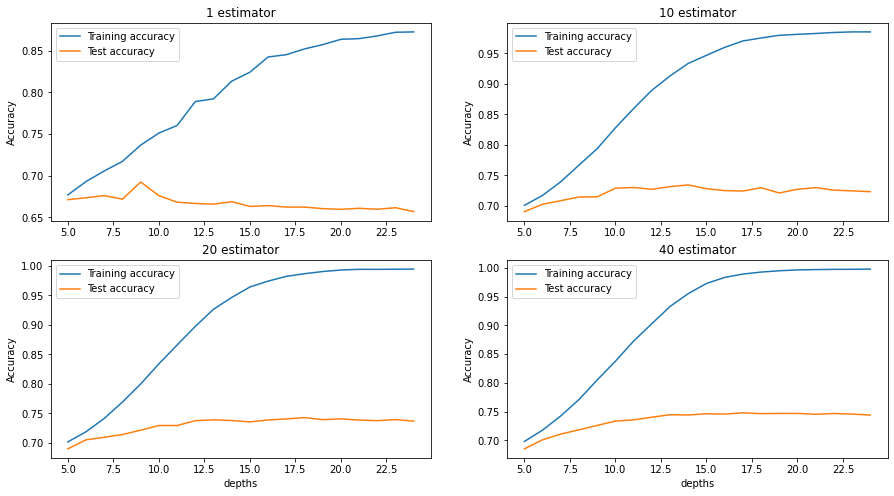

In [151]:
fig = plt.figure(figsize =(15,8))
ax1 = fig.add_subplot(2,2,1)
plt.title("1 estimator")
plt.plot(depths,tr_est1,label = "Training accuracy")
plt.plot(depths,test_est1,label = "Test accuracy")
plt.legend()
plt.ylabel('Accuracy')
ax2 = fig.add_subplot(2,2,2)
plt.title("10 estimator")
plt.plot(depths,tr_est10,label = "Training accuracy")
plt.plot(depths,test_est10,label = "Test accuracy")
plt.legend()
plt.ylabel('Accuracy')
ax3 = fig.add_subplot(2,2,3)
plt.title("20 estimator")
plt.plot(depths,tr_est20,label = "Training accuracy")
plt.plot(depths,test_est20,label = "Test accuracy")
plt.legend()
plt.xlabel('depths')
plt.ylabel('Accuracy')
ax4 = fig.add_subplot(2,2,4)
plt.title("40 estimator")
plt.plot(depths,tr_est40,label = "Training accuracy")
plt.plot(depths,test_est40,label = "Test accuracy")
plt.legend()
plt.xlabel('depths')
plt.ylabel('Accuracy')


n_estimators = 20 is optimal for all the graphs because there aren't further significant improvements after it. For the depth of tree we will run another selectino over a more restriced and finite grid.

In [152]:
max(test_est20),max(test_est40)

(0.7428808386766275, 0.7478081609761901)

In [153]:
depths = range(3,35)
bag_train_score = []
bag_test_score = []
for el in depths:
    clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = el, random_state = 6)
    bag_score = cross_validate(BaggingClassifier(base_estimator=clf, n_estimators=40,random_state=8), X_train, y_train, cv=skf,return_train_score=True,n_jobs=-1)
    bag_train_score.append(np.mean(bag_score['train_score']))
    bag_test_score.append(np.mean(bag_score['test_score']))

In [154]:
bag_test_score

[0.6401891780998186,
 0.6697563652166736,
 0.6877919429358051,
 0.7043478429763502,
 0.7121321624620344,
 0.7206069625892538,
 0.7252388640573749,
 0.7332213446891988,
 0.7353892208299849,
 0.7407119913956984,
 0.7434705635283464,
 0.7475119632326341,
 0.7460332566941904,
 0.744456756343366,
 0.7472158626030925,
 0.7477085705545453,
 0.7471178745626835,
 0.7484972334645181,
 0.7488921961605974,
 0.7492859449314982,
 0.7479065860296635,
 0.7490895318376156,
 0.7479058576745563,
 0.7477084248835238,
 0.7481037274786531,
 0.7475120603466484,
 0.7461325072167851,
 0.7470193523951958,
 0.7467237858927327,
 0.7470196437372386,
 0.747315016011673,
 0.7470194495092101]

Text(0, 0.5, 'Accuracy')

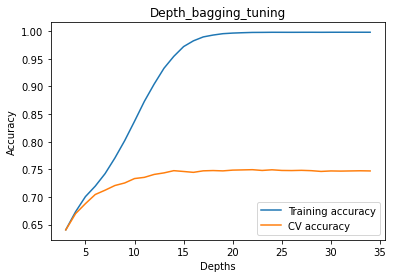

In [155]:
plt.title("Depth_bagging_tuning")
plt.plot(depths,bag_train_score,label = "Training accuracy")
plt.plot(depths,bag_test_score,label = "CV accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

We can see from the graph where we can cut the depth (15) or pick the best (25). Here there is the prediction on our split.

In [156]:
clf_tuned = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 15, random_state = 12)
bag_lrn = BaggingClassifier(base_estimator=clf_tuned, n_estimators=40, random_state=12)
bag_lrn = bag_lrn.fit(X_train, y_train)
y_p = bag_lrn.predict(X_test)
y_t = bag_lrn.predict(X_train)
print("Bagging training accuracy is", accuracy_score(y_train, y_t))
print("Bagging test accuracy is", accuracy_score(y_test, y_p))

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bagging training accuracy is 0.9631418153148714
Bagging test accuracy is 0.7611351990540007


In [157]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1095
           1       0.77      0.83      0.80      1442

    accuracy                           0.76      2537
   macro avg       0.76      0.75      0.75      2537
weighted avg       0.76      0.76      0.76      2537



In [158]:
cohen_kappa_score(y_test, y_p)

0.506657810123414

In [159]:
scores = cross_validate(BaggingClassifier(base_estimator= clf_tuned, n_estimators = 20, random_state=24), X, y, cv=5, return_train_score = True)
scores['train_score'].mean(),scores['test_score'].mean()

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

(0.9569930884736977, 0.7468470112368493)

In [160]:
# It doesn't work in reasonable time -> it is tuning both max_depth and n_estimators

# depths = range(1,20,2)
# bag_train_mean = []
# bag_val_mean = []
# for el in depths:
#    tree_lrn = DecisionTreeClassifier(max_depth = el)
#    estimators = [1,10,20,50]
#    bag_train_score, bag_val_score = validation_curve(BaggingClassifier(base_estimator=tree_lrn), X, y, 'n_estimators', estimators, cv=5)
#    for el in range(len(train_score)):
#        bag_train_mean.append(bag_train_score[el].mean())
#        bag_val_mean.append(bag_val_score[el].mean())
# bag_train_mean,bag_val_mean

In [161]:
# train_perf_bag = []
# test_perf_bag = []
# estimators = []
# for max_d in [1,10,50,100,150,200]:
#  bag_lrn = BaggingClassifier(base_estimator = clf, n_estimators=max_d)
#  bag_lrn.fit(X_train, y_train)
#  print('The Training Accuracy for estimators {} is:'.format(max_d), bag_lrn.score(X_train, y_train))
#  train_perf_bag.append(bag_lrn.score(X_train, y_train))
#  print('The test Accuracy for estimators {} is:'.format(max_d), bag_lrn.score(X_test,y_test))
#  test_perf_bag.append(bag_lrn.score(X_test,y_test))
#  estimators.append(max_d)
#  print('')

In [162]:
# plt.title("Estimators_tuning")
# plt.plot(estimators,train_perf_bag,label = "Training accuracy")
# plt.plot(estimators,test_perf_bag,label = "Test accuracy")
# plt.legend()
# plt.xlabel('Estimators')
# plt.ylabel('Accuracy')

In [163]:
# for max_d in [1,20,50,100]:
#    bag_lrn = BaggingClassifier(base_estimator = clf, n_estimators=max_d)
#    scores = cross_val_score(bag_lrn, X, y, cv=5)
#    print(scores, scores.mean())

In [164]:
#TRYING THE FULL DEPTH TO COMPARE

# n_estimators = range(1,101,20)
# tree_lrn = tree.DecisionTreeClassifier(criterion = "entropy")
# train_score, val_score = validation_curve(BaggingClassifier(base_estimator= tree_lrn), X, y, param_name='n_estimators', param_range=n_estimators, cv=skf)
# train_score, val_score

In [165]:
# plt.title('estimators with full depth')
# plt.plot(n_estimators, np.mean(val_score, 1), label='Testing accuracy')
# plt.plot(n_estimators, np.mean(train_score, 1), label='Training accuracy')
# plt.legend()
# plt.xlabel('Estimators')
#plt.ylabel('Accuracy')
# plt.show()

# RANDOM FOREST

In [166]:
rf_lrn = RandomForestClassifier(criterion="entropy", n_estimators=1)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(rf_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

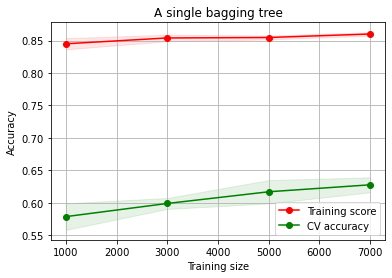

In [167]:
plt.title('A single bagging tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [168]:
rf_lrn = RandomForestClassifier(criterion="entropy", n_estimators=10)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(rf_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

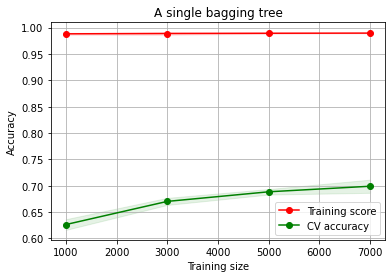

In [169]:
plt.title('A single bagging tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [170]:
rf_lrn = RandomForestClassifier(criterion="entropy", n_estimators=20)
sizes = range(1000, 8001, 2000)
train_size, train_score, val_score = learning_curve(rf_lrn, X_train, y_train, train_sizes=sizes, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

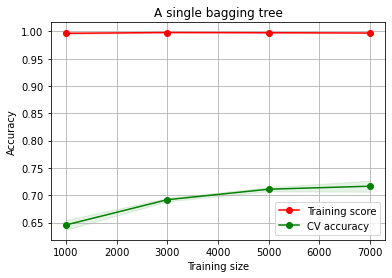

In [171]:
plt.title('A single bagging tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

In [172]:
depths = range(3,35)
rf_train_score = []
rf_test_score = []
for el in depths:
    rf_score = cross_validate(RandomForestClassifier(criterion = "entropy",max_depth=el, n_estimators=40), X_train, y_train, cv=skf,return_train_score=True,n_jobs=-1)
    rf_train_score.append(np.mean(rf_score['train_score']))
    rf_test_score.append(np.mean(rf_score['test_score']))
rf_test_score

[0.6241244807435049,
 0.6530974757639839,
 0.6726115657935307,
 0.6808895158138033,
 0.692124733239942,
 0.7002064158373534,
 0.7072031406672219,
 0.7121305115237917,
 0.7158756163705093,
 0.7219866613901386,
 0.7289828035359212,
 0.7293770864339006,
 0.7341067331573952,
 0.7383454685387012,
 0.7387405283487947,
 0.734699177201514,
 0.7436674136352932,
 0.7345025698796028,
 0.7359802081638895,
 0.736965624066795,
 0.7358808119702733,
 0.7377532672796179,
 0.7374578950051834,
 0.7368668105572644,
 0.7387391687525948,
 0.7380509702903952,
 0.7355856339238674,
 0.7366696691082748,
 0.7399226001306184,
 0.7430763291873742,
 0.7401192074525295,
 0.733417660669067]

Text(0, 0.5, 'Accuracy')

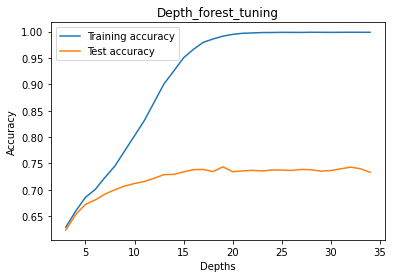

In [173]:
plt.title("Depth_forest_tuning")
plt.plot(depths,rf_train_score,label = "Training accuracy")
plt.plot(depths,rf_test_score,label = "Test accuracy")
plt.legend()
plt.xlabel('Depths')
plt.ylabel('Accuracy')

In [174]:
k_grid = {'max_depth': range(3,35),'n_estimators': range(10,41,5)}
learner = GridSearchCV(estimator=RandomForestClassifier(criterion = "entropy",random_state=21), param_grid=k_grid, cv=skf, return_train_score=True,n_jobs=-1)
learner.fit(X_train, y_train)
learner.best_params_, learner.best_score_ #check the previous graph

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


({'max_depth': 19, 'n_estimators': 40}, 0.7412030484089083)

In [175]:
clf_tuned = learner.best_estimator_
rf_lrn = clf_tuned.fit(X_train, y_train)
y_p = rf_lrn.predict(X_test)
y_t = rf_lrn.predict(X_train)
print("Bagging accuracy is", accuracy_score(y_train, y_t))
print("Bagging test accuracy is", accuracy_score(y_test, y_p))

<ipython-input-175-bd2011281eaf>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn = clf_tuned.fit(X_train, y_train)


Bagging accuracy is 0.9882723957820045
Bagging test accuracy is 0.7599527000394166


In [176]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      1095
           1       0.77      0.83      0.80      1442

    accuracy                           0.76      2537
   macro avg       0.76      0.75      0.75      2537
weighted avg       0.76      0.76      0.76      2537



In [177]:
cohen_kappa_score(y_test, y_p)

0.5039393438333272

In [178]:
scores = cross_validate(clf_tuned, X, y, cv=5, return_train_score = True,n_jobs=-1)
scores['train_score'].mean(),scores['test_score'].mean()

(0.9880163935438763, 0.7444823862357612)

In [179]:
#k_grid = {'max_depth': range(1,20,3),'min_samples_leaf': range(1,16,5),'min_samples_split':range(3,19,5),'n_estimators': range(1,51,5)}
#learner = GridSearchCV(estimator=RandomForestClassifier(criterion = "entropy",random_state=33), param_grid=k_grid, cv=skf, return_train_score=True,n_jobs=-1)
#learner.fit(X, y)
#learner.best_params_, learner.best_score_ # really slow -> runtime problem! Value reported in the next cell rf_lrn

Best couple of paramters are (roughly) max_depth = 10 and n_estimators depends on the considered range. Especially, varying the estimator range the max_depth doesn't move (at most it goes to 13) from the value 10. (try it in the previous cell and in the graph). Previous output: 'max_depth': 16,'min_samples_leaf': 6,'min_samples_split': 18,'n_estimators': 46},

In [180]:
# evaluated for the given split
rf_lrn = RandomForestClassifier(criterion = "entropy",max_depth = learner.best_params_['max_depth'], n_estimators = learner.best_params_['n_estimators'], random_state = 21)
rf_lrn_fit = rf_lrn.fit(X_train, y_train)
y_p = rf_lrn_fit.predict(X_test)
y_t = rf_lrn_fit.predict(X_train)
print("Random Forest training accuracy is", accuracy_score(y_train, y_t))
print("Random Forest test accuracy is", accuracy_score(y_test, y_p))

<ipython-input-180-f9d4b293409e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn_fit = rf_lrn.fit(X_train, y_train)


Random Forest training accuracy is 0.9882723957820045
Random Forest test accuracy is 0.7599527000394166


In [181]:
scores = cross_validate(rf_lrn, X, y, cv=5, return_train_score = True)
scores['train_score'].mean(),scores['test_score'].mean() # real estimation of the accuracy with all the paramters tuned

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

(0.9880163935438763, 0.7444823862357612)

Similar performances of bagging

In [182]:
#rf_lrn = RandomForestClassifier(n_estimators=10, max_depth=10)
#sizes = range(1000, 8001, 2000)
#train_size, train_score, val_score = learning_curve(rf_lrn, X, y, train_sizes=sizes, cv=skf)

In [183]:
#plt.title('Random Forest')
#train_score_mean = np.mean(train_score, axis=1)
#train_score_std = np.std(train_score, axis=1)
#val_score_mean = np.mean(val_score, axis=1)
#val_score_std = np.std(val_score, axis=1)
#plt.grid()
#plt.fill_between(train_size, train_score_mean - train_score_std,
#                 train_score_mean + train_score_std, alpha=0.1,
#                 color="r")
#plt.fill_between(train_size, val_score_mean - val_score_std,
#                 val_score_mean + val_score_std, alpha=0.1, color="g")
#plt.plot(train_size, train_score_mean, 'o-', color="r",
#         label="Training score")
#plt.plot(train_size, val_score_mean, 'o-', color="g",
#         label="CV accuracy")
#plt.legend()
#plt.xlabel('Training size')
#plt.ylabel('Accuracy')
#plt.show()

In [184]:
#depths = np.arange(3,31,3)
#learner = RandomForestClassifier(n_estimators=10)
#train_score, val_score = validation_curve(learner, X, y, 'max_depth', depths, cv=skf)

In [185]:
#plt.title('Random Forest')
#train_score_mean = np.mean(train_score, axis=1)
#train_score_std = np.std(train_score, axis=1)
#val_score_mean = np.mean(val_score, axis=1)
#val_score_std = np.std(val_score, axis=1)
#plt.grid()
#plt.fill_between(depths, train_score_mean - train_score_std,
#                 train_score_mean + train_score_std, alpha=0.1,
#                 color="r")
#plt.fill_between(depths, val_score_mean - val_score_std,
#                 val_score_mean + val_score_std, alpha=0.1, color="g")
#plt.plot(depths, train_score_mean, 'o-', color="r",
#         label="Training score")
#plt.plot(depths, val_score_mean, 'o-', color="g",
#         label="CV accuracy")
#plt.legend()
#plt.xlabel('Tree depth')
#plt.ylabel('Accuracy')
#plt.show()

In [186]:
num_trees = [1,10,100]
tree_lrn = DecisionTreeClassifier(splitter='random', min_samples_split=20, min_samples_leaf=10)
bag_lrn = BaggingClassifier(base_estimator=tree_lrn)
rf_lrn = RandomForestClassifier(max_depth=9, min_samples_split=20, min_samples_leaf=10)
train_score, bag_val_score = validation_curve(bag_lrn, X, y, param_name='n_estimators', param_range=num_trees, cv=skf)
train_score, rf_val_score = validation_curve(rf_lrn, X, y, param_name='n_estimators', param_range=num_trees, cv=skf)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

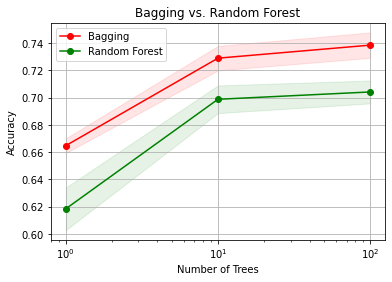

In [187]:
plt.title('Bagging vs. Random Forest')
bag_val_score_mean = np.mean(bag_val_score, axis=1)
bag_val_score_std = np.std(bag_val_score, axis=1)
rf_val_score_mean = np.mean(rf_val_score, axis=1)
rf_val_score_std = np.std(rf_val_score, axis=1)
plt.grid()
plt.xscale("log")
plt.fill_between(num_trees, bag_val_score_mean - bag_val_score_std,
                 bag_val_score_mean + bag_val_score_std, alpha=0.1,
                 color="r")
plt.fill_between(num_trees, rf_val_score_mean - rf_val_score_std,
                 rf_val_score_mean + rf_val_score_std, alpha=0.1, color="g")
plt.plot(num_trees, bag_val_score_mean, 'o-', color="r",
         label="Bagging")
plt.plot(num_trees, rf_val_score_mean, 'o-', color="g",
         label="Random Forest")
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

In [188]:
train_perf_rf = []
test_perf_rf = []
estimators = []
for max_d in [1,10,50,100,150,200,300,500,1000]:
  rf_lrn = RandomForestClassifier(max_depth=9, n_estimators=max_d)
  rf_lrn.fit(X_train, y_train)
  print('The Training Accuracy for estimators {} is:'.format(max_d), rf_lrn.score(X_train, y_train))
  train_perf_rf.append(rf_lrn.score(X_train, y_train))
  print('The test Accuracy for estimators {} is:'.format(max_d), rf_lrn.score(X_test,y_test))
  test_perf_rf.append(rf_lrn.score(X_test,y_test))
  estimators.append(max_d)
  print('')

<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)
<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)
<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 1 is: 0.6693604020892875
The test Accuracy for estimators 1 is: 0.6448561292865589

The Training Accuracy for estimators 10 is: 0.7525376958707007
The test Accuracy for estimators 10 is: 0.7012219156484036

The Training Accuracy for estimators 50 is: 0.7674189415590815
The test Accuracy for estimators 50 is: 0.7098935750886874



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 100 is: 0.7667290824874347
The test Accuracy for estimators 100 is: 0.711864406779661



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 150 is: 0.7695870700699714
The test Accuracy for estimators 150 is: 0.7169885691761924



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 200 is: 0.7693899674780723
The test Accuracy for estimators 200 is: 0.7083169097359086



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 300 is: 0.765152261752242
The test Accuracy for estimators 300 is: 0.7142294048088293



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 500 is: 0.7701783778456687
The test Accuracy for estimators 500 is: 0.7162002364998029



<ipython-input-188-8f5160a642dd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lrn.fit(X_train, y_train)


The Training Accuracy for estimators 1000 is: 0.7690943135902237
The test Accuracy for estimators 1000 is: 0.7154119038234135



Text(0, 0.5, 'Accuracy')

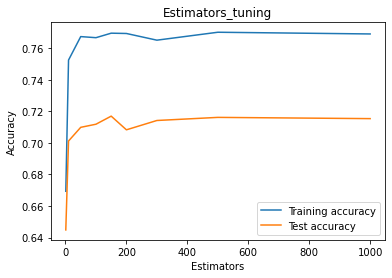

In [189]:
plt.title("Estimators_tuning")
plt.plot(estimators,train_perf_rf,label = "Training accuracy")
plt.plot(estimators,test_perf_rf,label = "Test accuracy")
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('Accuracy')

In [190]:
for max_d in [1,20,50,100]:
    bag_lrn = RandomForestClassifier(max_depth = 15,n_estimators=max_d)
    scores = cross_val_score(bag_lrn, X, y, cv=skf)
    print(scores, scores.mean())

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

[0.64012613 0.62633031 0.6369728  0.63500197 0.63485804] 0.6346578524276045


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

[0.73985022 0.71974773 0.71462357 0.72881356 0.73146688] 0.7269003915551415


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

[0.74260938 0.72960189 0.72723689 0.74024438 0.73856467] 0.7356514438051848


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

[0.74615688 0.74418605 0.73354356 0.74891604 0.74921136] 0.7444027758262883


# PCA

In [191]:
from sympy import Matrix

In [192]:
prova

,Y,Cluster_1,Cluster_2,Cluster_3,destination_No Urgent Place,destination_Work,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Snowy,...,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_1,toCoupon_GEQ25min_1,direction_same_1,direction_opp_1,rich_1,middleclass_1
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
1,1,0,0,0,1,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
10143,1,1,0,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
10144,1,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
10145,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,1,0


In [193]:
U, s, Vh = LA.svd(prova.T, full_matrices=False)
U.shape, s.shape, Vh.shape

((95, 95), (95,), (95, 10147))

In [195]:
P = U[:,:2] # the first two columns of U
R = P.T @ prova.T

In [196]:
R.shape

(2, 10147)

In [199]:
s

array([2.49314466e+02, 8.35809984e+01, 7.97563629e+01, 7.80276569e+01,
       7.32569601e+01, 6.71825050e+01, 6.16947062e+01, 5.84604663e+01,
       5.84474547e+01, 5.55974293e+01, 5.47534550e+01, 5.37473131e+01,
       5.17146842e+01, 5.12537440e+01, 4.96158104e+01, 4.84382619e+01,
       4.82917364e+01, 4.73621035e+01, 4.61796158e+01, 4.56331600e+01,
       4.38420013e+01, 4.36073992e+01, 4.32219350e+01, 4.21060785e+01,
       4.12978174e+01, 4.07150600e+01, 3.96917501e+01, 3.80105200e+01,
       3.78430152e+01, 3.74778224e+01, 3.60063934e+01, 3.51546626e+01,
       3.50575409e+01, 3.46454534e+01, 3.36904693e+01, 3.34000223e+01,
       3.25601628e+01, 3.20490767e+01, 3.19767137e+01, 3.16316423e+01,
       2.97278855e+01, 2.89299616e+01, 2.86855427e+01, 2.85779339e+01,
       2.82652655e+01, 2.77198247e+01, 2.64145767e+01, 2.62128366e+01,
       2.58563106e+01, 2.52616276e+01, 2.48623444e+01, 2.44572712e+01,
       2.36603155e+01, 2.33855063e+01, 2.29839851e+01, 2.22617659e+01,
      

# K-NN

In [200]:
from sklearn.neighbors import KNeighborsClassifier as kNN

In [201]:
knn = kNN(n_neighbors=1)
knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(0.9985217305607569, 0.6602286164761529)

In [202]:
k_train_acc = []
k_test_acc =[]
neig = []
for n in range(1,11):
    knn = kNN(n_neighbors=n)
    knn.fit(X_train, y_train)
    k_train_acc.append(knn.score(X_train, y_train))
    k_test_acc.append(knn.score(X_test, y_test))
    neig.append(n)
    

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

Text(0, 0.5, 'Accuracy')

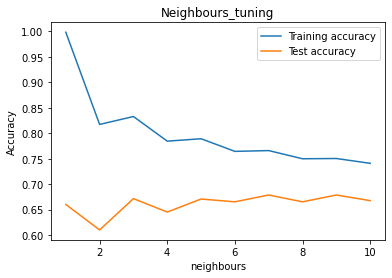

In [203]:
plt.title("Neighbours_tuning")
plt.plot(neig,k_train_acc,label = "Training accuracy")
plt.plot(neig,k_test_acc,label = "Test accuracy")
plt.legend()
plt.xlabel('neighbours')
plt.ylabel('Accuracy')

K-NN perform worse than trees (random and bagging) as we expected. This because encoded features in the 0-1 space don't reflect geometric relationship in the space (which is the basic concept of K-NN)

In [204]:
k_grid = {'n_neighbors': range(10,51,5)}
learner = GridSearchCV(estimator=kNN(), param_grid=k_grid, cv=5, return_train_score=True)
learner.fit(X, y)
learner.best_params_, learner.best_score_ #check the previous graph

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

({'n_neighbors': 50}, 0.696625805585225)

In [205]:
scores = cross_validate(kNN(n_neighbors = learner.best_params_['n_neighbors']), X, y, cv=5, return_train_score = True)
scores['train_score'].mean(),scores['test_score'].mean()

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

(0.7198241991716642, 0.696625805585225)

Outperformed by trees